<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: calwebb_image3 with MIRI

<span style="color:red"> **Instruments Affected**</span>: MIRI, NIRCam 

## Summary

This notebook processes a set of simulated images through the full pipeline, with emphasis on the calwebb_image3 pipeline.

1) Read in images.

2) Run images through the detector1 and image2 pipelines to get calibrated images.

3) Set up association file.

4) Run image3 pipeline with association file as input.

5) Display and examine combined image.


The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst

Author: T. Temim and M. Cracraft

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp'>


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


### Set up import statements

In [3]:
import pytest
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import jwst
import json
import glob
#from jwst.pipeline import Image2Pipeline
#from jwst.pipeline import Image3Pipeline
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.datamodels import ImageModel
from jwst.pipeline import calwebb_image3
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst.associations import asn_from_list
from jwst import datamodels
from matplotlib import rcParams
from ci_watson.artifactory_helpers import get_bigdata

### Print pipeline version number

In [4]:
jwst.__version__ 

'1.8.2'

### Set up data path and image list file

In [5]:
print("Downloading input files")
 
#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

filelist = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 
            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits']

for file in filelist:
    input_file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test',
                     file)

print("Finished Downloads")


Finished Downloads


### Run files through detector one and Image2 pipelines to get most up to date calibrated files

In [6]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

print('There are ', len(filelist), ' images.')
    
slopelist = []    
    
# loop over list of files
for file in filelist:
    
    # set up pipeline parameters for input
    pipe1 = Detector1Pipeline()
    pipe1.jump.rejection_threshold = rej_thresh
    pipe1.jump.override_readnoise = readnoise
    pipe1.ramp_fit.override_readnoise = readnoise
    pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
       
    # set up output file name
    base, remainder = file.split('.')
    outname = base
        
    pipe1.jump.output_file = outname+'.fits'    
    #pipe1.ramp_fit.output_file = outname+'.fits'
    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
    rampfile = pipe1.run(file)
    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

print('Detector 1 steps completed on all files.')
print(slopelist)


2022-12-02 16:19:21,392 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:19:21,394 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:19:21,398 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:19:21,399 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:19:21,401 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:19:21,402 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:19:21,403 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:19:21,404 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:19:21,407 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:19:21,408 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:19:21,409 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:19:21,410 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:19:21,411 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:19:21,413 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:19:21,415 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:19:21,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:19:21,417 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:19:21,552 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits',).


2022-12-02 16:19:21,562 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

There are  8  images.


2022-12-02 16:19:22,851 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:19:25,245 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:19:25,247 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:19:25,250 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:19:25,251 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:19:25,252 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:19:25,254 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:19:25,255 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:19:25,256 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:19:25,258 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:19:25,259 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:19:25,261 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:19:25,261 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:19:25,262 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:19:25,264 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:19:25,934 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:25,936 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:26,314 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:19:26,316 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:19:26,320 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:19:26,574 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:26,577 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:26,616 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:19:27,240 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:19:27,380 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:27,382 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:19:27,406 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:19:31,907 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1071 saturated pixels


2022-12-02 16:19:31,973 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:19:31,985 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:19:32,122 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:32,124 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:32,146 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:19:32,147 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:19:32,148 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:19:32,495 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:19:32,616 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:32,618 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:32,974 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:19:33,096 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:33,099 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:33,452 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:19:33,580 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:33,582 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:33,608 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:19:35,173 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:19:35,297 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:35,299 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:19:35,323 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:19:36,774 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:19:36,902 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:36,904 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:19:36,928 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:19:37,344 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:19:37,472 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:37,475 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:19:37,500 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:19:52,179 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:19:52,180 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:19:53,524 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:19:53,681 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:53,683 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:19:53,684 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:19:53,687 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:19:53,806 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:19:53,808 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:19:53,818 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:19:53,834 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:19:53,859 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:19:54,437 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:19:54,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:19:57,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2982 pixels with at least one CR from five or more groups.


2022-12-02 16:19:58,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:20:00,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2445 pixels with at least one CR from five or more groups.


2022-12-02 16:20:01,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:20:04,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2541 pixels with at least one CR from five or more groups.


2022-12-02 16:20:04,619 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.1805 sec


2022-12-02 16:20:04,831 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 11.012779


2022-12-02 16:20:05,349 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits


2022-12-02 16:20:05,350 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:20:05,495 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:20:05,497 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:20:05,522 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:20:05,523 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:20:05,575 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:20:05,576 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:20:05,915 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:20:05,917 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:20:41,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:20:41,705 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:20:41,808 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:20:41,966 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:20:41,968 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:42,015 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:20:42,016 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:20:42,021 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:20:42,142 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:20:42,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:42,186 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:20:42,187 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:20:42,192 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:20:42,307 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rateints.fits


2022-12-02 16:20:42,308 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:20:42,309 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:20:42,377 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits


2022-12-02 16:20:42,378 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:20:42,387 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:20:42,389 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:20:42,391 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:20:42,392 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:20:42,394 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:20:42,396 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:20:42,397 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:20:42,399 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:20:42,401 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:20:42,403 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:20:42,405 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:20:42,406 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:20:42,408 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:20:42,410 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:20:42,411 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:20:42,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:20:42,414 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:20:42,532 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',).


2022-12-02 16:20:42,544 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:20:42,897 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:20:42,906 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:20:42,909 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:20:42,911 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:20:42,911 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:20:42,913 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:20:42,915 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:20:42,915 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:20:42,916 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:20:42,918 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:20:42,920 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:20:42,922 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:20:42,923 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:20:42,923 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:20:42,924 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:20:43,404 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:43,406 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:43,724 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:20:43,725 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:20:43,727 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:20:43,849 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:43,851 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:43,872 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:20:44,359 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:20:44,481 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:44,482 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:20:44,505 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:20:48,446 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1071 saturated pixels


2022-12-02 16:20:48,510 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:20:48,519 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:20:48,648 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:48,650 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:48,672 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:20:48,673 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:20:48,673 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:20:49,017 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:20:49,142 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:49,144 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:49,472 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:20:49,596 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:49,598 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:49,969 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:20:50,096 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:50,097 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:50,123 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:20:50,732 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:20:50,861 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:50,863 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:20:50,890 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:20:52,235 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:20:52,362 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:52,363 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:20:52,405 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:20:52,806 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:20:52,934 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:52,935 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:20:52,959 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:20:54,458 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:20:54,459 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:20:55,737 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:20:55,873 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:55,876 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:20:55,877 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:20:55,880 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:20:56,000 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:20:56,002 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:20:56,013 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:20:56,028 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:20:56,059 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:20:56,644 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:20:56,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:20:59,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2941 pixels with at least one CR from five or more groups.


2022-12-02 16:21:00,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:21:02,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2686 pixels with at least one CR from five or more groups.


2022-12-02 16:21:03,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:21:05,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2543 pixels with at least one CR from five or more groups.


2022-12-02 16:21:06,429 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.78331 sec


2022-12-02 16:21:06,646 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.633695


2022-12-02 16:21:07,158 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits


2022-12-02 16:21:07,159 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:21:07,286 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:21:07,288 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:21:07,312 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:21:07,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:21:07,366 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:21:07,367 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:21:07,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:21:07,693 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:21:41,845 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:21:41,847 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:21:41,938 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:21:42,096 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:21:42,098 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:42,155 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:21:42,156 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:21:42,161 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:21:42,282 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:21:42,284 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:42,326 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:21:42,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:21:42,332 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:21:42,442 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rateints.fits


2022-12-02 16:21:42,443 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:21:42,444 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:21:42,511 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits


2022-12-02 16:21:42,513 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:21:42,521 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:21:42,522 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:21:42,524 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:21:42,525 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:21:42,526 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:21:42,527 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:21:42,528 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:21:42,529 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:21:42,531 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:21:42,532 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:21:42,533 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:21:42,534 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:21:42,536 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:21:42,537 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:21:42,539 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:21:42,540 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:21:42,541 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:21:42,665 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',).


2022-12-02 16:21:42,676 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:21:43,060 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:21:43,067 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:21:43,069 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:21:43,070 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:21:43,071 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:21:43,073 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:21:43,074 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:21:43,075 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:21:43,076 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:21:43,078 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:21:43,079 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:21:43,081 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:21:43,082 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:21:43,082 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:21:43,083 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:21:43,610 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:43,612 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:43,949 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:21:43,950 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:21:43,954 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:21:44,079 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:44,081 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:44,103 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:21:44,592 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:21:44,718 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:44,719 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:21:44,742 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:21:48,629 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1100 saturated pixels


2022-12-02 16:21:48,689 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:21:48,698 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:21:48,823 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:48,825 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:48,847 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:21:48,848 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:21:48,848 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:21:49,181 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:21:49,301 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:49,303 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:49,641 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:21:49,761 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:49,763 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:50,105 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:21:50,230 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:50,232 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:50,256 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:21:50,864 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:21:50,993 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:50,995 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:21:51,017 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:21:52,300 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:21:52,426 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:52,427 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:21:52,451 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:21:52,831 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:21:52,956 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:52,958 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:21:52,980 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:21:54,290 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:21:54,291 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:21:55,568 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:21:55,719 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:55,721 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:21:55,722 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:21:55,725 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:21:55,844 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:21:55,847 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:21:55,857 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:21:55,873 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:21:55,898 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:21:56,464 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:21:56,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:21:59,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2858 pixels with at least one CR from five or more groups.


2022-12-02 16:21:59,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:22:02,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2639 pixels with at least one CR from five or more groups.


2022-12-02 16:22:02,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:22:05,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2384 pixels with at least one CR from five or more groups.


2022-12-02 16:22:06,009 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.54447 sec


2022-12-02 16:22:06,220 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.363141


2022-12-02 16:22:06,728 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits


2022-12-02 16:22:06,729 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:22:06,887 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:22:06,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:22:06,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:22:06,917 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:22:06,972 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:22:06,973 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:22:07,304 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:22:07,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:22:42,667 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:22:42,669 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:22:42,762 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:22:42,925 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:22:42,927 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:42,977 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:22:42,978 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:22:42,983 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:22:43,109 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:22:43,111 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:43,154 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:22:43,155 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:22:43,160 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:22:43,268 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rateints.fits


2022-12-02 16:22:43,269 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:22:43,270 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:22:43,336 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits


2022-12-02 16:22:43,337 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:22:43,345 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:22:43,346 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:22:43,348 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:22:43,349 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:22:43,350 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:22:43,351 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:22:43,352 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:22:43,353 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:22:43,354 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:22:43,355 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:22:43,356 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:22:43,357 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:22:43,358 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:22:43,360 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:22:43,361 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:22:43,362 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:22:43,364 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:22:43,486 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',).


2022-12-02 16:22:43,498 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:22:43,857 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:22:43,875 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:22:43,879 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:22:43,881 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:22:43,881 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:22:43,885 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:22:43,887 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:22:43,887 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:22:43,888 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:22:43,892 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:22:43,897 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:22:43,902 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:22:43,903 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:22:43,903 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:22:43,904 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:22:44,377 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:44,378 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:44,712 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:22:44,713 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:22:44,716 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:22:44,847 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:44,849 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:44,871 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:22:45,350 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:22:45,478 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:45,479 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:22:45,501 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:22:49,380 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1101 saturated pixels


2022-12-02 16:22:49,442 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:22:49,451 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:22:49,589 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:49,590 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:49,611 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:22:49,612 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:22:49,612 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:22:49,949 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:22:50,082 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:50,083 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:50,422 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:22:50,555 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:50,556 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:50,900 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:22:51,034 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:51,036 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:51,061 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:22:51,676 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:22:51,812 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:51,815 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:22:51,841 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:22:53,454 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:22:53,585 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:53,587 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:22:53,611 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:22:53,992 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:22:54,125 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:54,127 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:22:54,153 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:22:55,487 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:22:55,488 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:22:56,778 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:22:56,915 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:56,917 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:22:56,917 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:22:56,920 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:22:57,042 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:22:57,044 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:22:57,054 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:22:57,068 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:22:57,092 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:22:57,664 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:22:57,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:23:00,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2849 pixels with at least one CR from five or more groups.


2022-12-02 16:23:01,000 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:23:03,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2632 pixels with at least one CR from five or more groups.


2022-12-02 16:23:04,218 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:23:06,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2479 pixels with at least one CR from five or more groups.


2022-12-02 16:23:07,416 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.75142 sec


2022-12-02 16:23:07,634 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.579707


2022-12-02 16:23:08,146 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits


2022-12-02 16:23:08,147 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:23:08,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:23:08,281 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:23:08,305 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:23:08,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:23:08,357 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:23:08,358 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:23:08,699 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:23:08,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:23:45,549 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:23:45,552 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:23:45,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:23:45,810 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:23:45,812 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:45,869 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:23:45,870 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:23:45,874 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:23:46,000 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:23:46,002 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:46,044 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:23:46,045 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:23:46,049 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:23:46,158 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rateints.fits


2022-12-02 16:23:46,159 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:23:46,160 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:23:46,226 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits


2022-12-02 16:23:46,227 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:23:46,235 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:23:46,236 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:23:46,237 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:23:46,238 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:23:46,239 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:23:46,240 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:23:46,241 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:23:46,242 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:23:46,244 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:23:46,245 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:23:46,246 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:23:46,247 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:23:46,248 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:23:46,249 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:23:46,250 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:23:46,252 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:23:46,252 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:23:46,379 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',).


2022-12-02 16:23:46,389 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:23:46,774 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:23:46,800 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:23:46,802 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:23:46,804 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:23:46,804 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:23:46,806 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:23:46,808 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:23:46,809 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:23:46,809 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:23:46,812 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:23:46,813 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:23:46,816 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:23:46,817 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:23:46,817 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:23:46,818 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:23:47,340 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:47,341 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:47,682 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:23:47,683 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:23:47,686 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:23:47,819 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:47,821 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:47,844 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:23:48,340 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:23:48,477 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:48,479 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:23:48,502 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:23:52,394 - stpipe.Detector1Pipeline.saturation - INFO - Detected 957 saturated pixels


2022-12-02 16:23:52,456 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:23:52,464 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:23:52,600 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:52,601 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:52,622 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:23:52,623 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:23:52,623 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:23:52,963 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:23:53,096 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:53,098 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:53,444 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:23:53,579 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:53,580 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:53,927 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:23:54,065 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:54,066 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:54,092 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:23:54,715 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:23:54,857 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:54,858 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:23:54,881 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:23:56,345 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:23:56,483 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:56,485 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:23:56,507 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:23:56,892 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:23:57,029 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:57,030 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:23:57,053 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:23:58,423 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:23:58,424 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:23:59,734 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:23:59,881 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:23:59,883 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:23:59,883 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:23:59,886 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:24:00,010 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:24:00,012 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:24:00,022 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:24:00,036 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:24:00,060 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:24:00,636 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:24:00,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:24:03,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2601 pixels with at least one CR from five or more groups.


2022-12-02 16:24:03,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:24:06,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2274 pixels with at least one CR from five or more groups.


2022-12-02 16:24:07,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:24:09,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2368 pixels with at least one CR from five or more groups.


2022-12-02 16:24:10,197 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.55978 sec


2022-12-02 16:24:10,405 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.382928


2022-12-02 16:24:10,906 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits


2022-12-02 16:24:10,907 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:24:11,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:24:11,046 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:24:11,069 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:24:11,070 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:24:11,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:24:11,123 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:24:11,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:24:11,452 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:24:45,874 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:24:45,878 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:24:45,977 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:24:46,149 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:24:46,151 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:46,224 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:24:46,225 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:24:46,230 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:24:46,364 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:24:46,366 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:46,418 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:24:46,419 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:24:46,424 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:24:46,541 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rateints.fits


2022-12-02 16:24:46,542 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:24:46,542 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:24:46,611 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits


2022-12-02 16:24:46,612 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:24:46,620 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:24:46,621 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:24:46,622 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:24:46,624 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:24:46,625 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:24:46,625 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:24:46,627 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:24:46,628 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:24:46,629 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:24:46,630 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:24:46,631 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:24:46,632 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:24:46,633 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:24:46,634 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:24:46,636 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:24:46,637 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:24:46,638 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:24:46,767 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',).


2022-12-02 16:24:46,777 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:24:47,136 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:24:47,141 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:24:47,142 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:24:47,143 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:24:47,144 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:24:47,145 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:24:47,147 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:24:47,147 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:24:47,148 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:24:47,149 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:24:47,150 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:24:47,152 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:24:47,152 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:24:47,153 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:24:47,153 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:24:47,632 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:47,633 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:47,965 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:24:47,966 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:24:47,968 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:24:48,097 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:48,099 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:48,122 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:24:48,647 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:24:48,776 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:48,777 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:24:48,799 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:24:52,765 - stpipe.Detector1Pipeline.saturation - INFO - Detected 957 saturated pixels


2022-12-02 16:24:52,827 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:24:52,836 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:24:52,969 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:52,971 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:52,993 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:24:52,993 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:24:52,994 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:24:53,326 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:24:53,459 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:53,461 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:53,801 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:24:53,934 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:53,935 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:54,272 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:24:54,402 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:54,404 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:54,429 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:24:56,095 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:24:56,231 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:56,233 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:24:56,257 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:24:58,355 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:24:58,623 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:58,625 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:24:58,655 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:24:59,066 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:24:59,358 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:24:59,359 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:24:59,384 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:25:24,309 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:25:24,311 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:25:25,750 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:25:26,088 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:25:26,090 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:25:26,091 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:25:26,095 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:25:26,372 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:25:26,376 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:25:26,391 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:25:26,409 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:25:26,438 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:25:27,018 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:25:27,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:25:29,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2838 pixels with at least one CR from five or more groups.


2022-12-02 16:25:30,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:25:33,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2162 pixels with at least one CR from five or more groups.


2022-12-02 16:25:33,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:25:36,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2259 pixels with at least one CR from five or more groups.


2022-12-02 16:25:37,133 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.1135 sec


2022-12-02 16:25:37,384 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.993192


2022-12-02 16:25:37,997 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits


2022-12-02 16:25:37,998 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:25:38,163 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:25:38,165 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:25:38,190 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:25:38,191 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:25:38,245 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:25:38,246 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:25:38,597 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:25:38,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:26:13,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:26:13,580 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:26:13,678 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:26:13,834 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:26:13,836 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:13,881 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:26:13,882 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:26:13,886 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:26:14,011 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:26:14,012 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:14,054 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:26:14,054 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:26:14,059 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:26:14,172 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rateints.fits


2022-12-02 16:26:14,172 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:26:14,173 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:26:14,236 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits


2022-12-02 16:26:14,237 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:26:14,245 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:26:14,246 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:26:14,247 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:26:14,248 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:26:14,249 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:26:14,250 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:26:14,251 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:26:14,252 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:26:14,253 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:26:14,254 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:26:14,255 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:26:14,256 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:26:14,257 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:26:14,258 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:26:14,259 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:26:14,260 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:26:14,262 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:26:14,387 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',).


2022-12-02 16:26:14,396 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:26:14,758 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:26:14,765 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:26:14,767 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:26:14,768 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:26:14,769 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:26:14,770 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:26:14,772 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:26:14,772 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:26:14,773 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:26:14,774 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:26:14,776 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:26:14,777 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:26:14,777 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:26:14,778 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:26:14,778 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:26:15,262 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:15,264 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:15,594 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:26:15,595 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:26:15,598 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:26:15,727 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:15,728 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:15,750 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:26:16,227 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:26:16,356 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:16,358 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:26:16,379 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:26:20,242 - stpipe.Detector1Pipeline.saturation - INFO - Detected 971 saturated pixels


2022-12-02 16:26:20,302 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:26:20,310 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:26:20,438 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:20,439 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:20,460 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:26:20,460 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:26:20,461 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:26:20,788 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:26:20,915 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:20,916 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:21,254 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:26:21,380 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:21,381 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:21,715 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:26:21,841 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:21,842 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:21,864 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:26:22,477 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:26:22,603 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:22,605 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:26:22,626 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:26:23,857 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:26:23,986 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:23,987 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:26:24,009 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:26:24,382 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:26:24,513 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:24,515 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:26:24,537 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:26:25,990 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:26:25,991 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:26:27,387 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:26:27,526 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:27,528 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:26:27,529 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:26:27,532 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:26:27,656 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-12-02 16:26:27,659 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:26:27,669 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:26:27,686 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:26:27,715 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:26:28,291 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:26:28,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:26:30,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2614 pixels with at least one CR from five or more groups.


2022-12-02 16:26:31,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:26:34,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2258 pixels with at least one CR from five or more groups.


2022-12-02 16:26:34,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:26:37,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2515 pixels with at least one CR from five or more groups.


2022-12-02 16:26:37,719 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.42729 sec


2022-12-02 16:26:37,934 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.265039


2022-12-02 16:26:38,436 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits


2022-12-02 16:26:38,436 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:26:38,570 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:26:38,571 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:26:38,595 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:26:38,595 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:26:38,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:26:38,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:26:38,968 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:26:38,970 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:27:15,014 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:27:15,016 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:27:15,109 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:27:15,270 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:27:15,272 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:15,316 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:27:15,316 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:27:15,321 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:27:15,449 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-12-02 16:27:15,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:15,493 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:27:15,494 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:27:15,498 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:27:15,608 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rateints.fits


2022-12-02 16:27:15,609 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:27:15,609 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:27:15,673 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits


2022-12-02 16:27:15,674 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-02 16:27:15,682 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-02 16:27:15,683 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-02 16:27:15,684 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-02 16:27:15,685 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-02 16:27:15,686 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-02 16:27:15,687 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-02 16:27:15,688 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-02 16:27:15,689 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-02 16:27:15,690 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-02 16:27:15,691 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-02 16:27:15,693 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-02 16:27:15,694 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-02 16:27:15,695 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-02 16:27:15,696 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-02 16:27:15,697 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-02 16:27:15,698 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-02 16:27:15,699 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-02 16:27:15,826 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits',).


2022-12-02 16:27:15,836 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-12-02 16:27:16,196 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-02 16:27:16,203 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-02 16:27:16,205 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-02 16:27:16,206 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-12-02 16:27:16,206 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-02 16:27:16,208 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-02 16:27:16,209 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-02 16:27:16,209 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits'.


2022-12-02 16:27:16,210 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-02 16:27:16,211 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-02 16:27:16,212 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-02 16:27:16,214 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-02 16:27:16,214 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-02 16:27:16,214 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-02 16:27:16,215 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-02 16:27:16,720 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:16,722 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:17,058 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-02 16:27:17,059 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-02 16:27:17,062 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-02 16:27:17,200 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:17,201 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:17,223 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-02 16:27:17,707 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-02 16:27:17,846 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:17,847 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-12-02 16:27:17,870 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-02 16:27:21,905 - stpipe.Detector1Pipeline.saturation - INFO - Detected 975 saturated pixels


2022-12-02 16:27:21,965 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-02 16:27:21,973 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-02 16:27:22,103 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:22,105 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:22,126 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-12-02 16:27:22,126 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-12-02 16:27:22,126 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-12-02 16:27:22,460 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-02 16:27:22,601 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:22,603 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:22,943 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-02 16:27:23,082 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:23,083 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:23,422 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-02 16:27:23,556 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:23,558 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:23,581 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-02 16:27:24,196 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-02 16:27:24,335 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:24,336 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:27:24,360 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-02 16:27:25,703 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-02 16:27:25,839 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:25,841 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-12-02 16:27:25,863 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-02 16:27:26,250 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-02 16:27:26,393 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:26,394 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-12-02 16:27:26,417 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-02 16:27:27,838 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-12-02 16:27:27,839 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-02 16:27:29,270 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-02 16:27:29,413 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:29,415 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-02 16:27:29,415 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-12-02 16:27:29,418 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-02 16:27:29,556 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-12-02 16:27:29,558 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-02 16:27:29,568 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-12-02 16:27:29,583 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:27:29,609 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:27:30,185 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-02 16:27:30,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-02 16:27:32,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2560 pixels with at least one CR from five or more groups.


2022-12-02 16:27:33,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-02 16:27:36,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2391 pixels with at least one CR from five or more groups.


2022-12-02 16:27:36,538 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-12-02 16:27:39,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2417 pixels with at least one CR from five or more groups.


2022-12-02 16:27:39,619 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.43312 sec


2022-12-02 16:27:39,830 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.261778


2022-12-02 16:27:40,332 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits


2022-12-02 16:27:40,333 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-02 16:27:40,470 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:27:40,472 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-02 16:27:40,495 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/jwst_mirisim_readnoise.fits


2022-12-02 16:27:40,496 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-02 16:27:40,548 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-02 16:27:40,548 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-02 16:27:40,877 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-02 16:27:40,879 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-02 16:28:14,805 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-12-02 16:28:14,807 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-12-02 16:28:14,900 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-02 16:28:15,075 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:28:15,076 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:28:15,117 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:28:15,117 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:28:15,122 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:28:15,255 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-12-02 16:28:15,256 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-12-02 16:28:15,299 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-02 16:28:15,299 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-02 16:28:15,304 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-02 16:28:15,418 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rateints.fits


2022-12-02 16:28:15,419 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-02 16:28:15,419 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:15,486 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits


2022-12-02 16:28:15,487 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed on all files.
[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>]


In [7]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')
    
callist = []

# cycle through files
for rampfile in slopelist:
    
    # create an object for the pipeline    
    pipe2 = Image2Pipeline()

    filename = rampfile.meta.filename
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)

2022-12-02 16:28:15,500 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:15,502 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:15,503 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:15,504 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:15,506 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:15,507 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:15,640 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:15,646 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:15,654 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:15,665 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:15,667 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:15,668 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:15,668 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:15,669 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:15,669 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:15,671 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:15,672 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:15,673 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:15,674 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:15,676 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:15,676 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:15,677 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:15,677 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:15,678 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:15,678 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:15,679 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:15,679 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:15,680 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:15,681 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:15,681 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:15,682 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:15,683 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:15,683 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


There are  8  images.


2022-12-02 16:28:15,720 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:15,721 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-12-02 16:28:15,861 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:15,863 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:16,107 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:16,209 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-12-02 16:28:16,210 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-12-02 16:28:16,211 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:16,253 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:16,261 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:16,262 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:16,275 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:16,418 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:16,419 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:16,854 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:16,855 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:16,855 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:16,862 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:16,998 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:17,142 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:17,143 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:17,168 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:17,169 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:17,257 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:17,258 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:17,259 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:17,259 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:17,365 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:17,367 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:17,368 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:17,369 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:17,384 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:17,529 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:17,531 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:17,558 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:17,580 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:17,581 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:17,582 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:17,582 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:17,582 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:17,722 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:18,343 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:18,538 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:19,129 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:19,362 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:19,937 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:20,134 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:20,738 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:20,932 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:20,964 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019529633 -0.016360379 0.022280129 0.014982155 359.990661583 0.017756872 359.987911088 -0.013585662


2022-12-02 16:28:21,096 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2022-12-02 16:28:21,097 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:21,098 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:21,100 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:21,101 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:21,268 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2022-12-02 16:28:21,268 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:21,273 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:21,274 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:21,275 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:21,276 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:21,277 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:21,278 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:21,423 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:21,428 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:21,435 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:21,443 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:21,444 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:21,444 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:21,445 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:21,445 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:21,445 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:21,446 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:21,447 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:21,447 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:21,448 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:21,449 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:21,450 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:21,450 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:21,451 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:21,451 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:21,451 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:21,452 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:21,452 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:21,453 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:21,453 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:21,454 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:21,454 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:21,454 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:21,455 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:21,488 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:21,489 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-12-02 16:28:21,634 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:21,636 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:21,824 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:21,898 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-12-02 16:28:21,900 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-12-02 16:28:21,900 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:21,946 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:21,954 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:21,955 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:21,969 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:22,113 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:22,115 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:22,232 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:22,234 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:22,235 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:22,242 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:22,390 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:22,546 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:22,548 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:22,574 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:22,575 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:22,661 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:22,662 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:22,663 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:22,663 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:22,711 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:22,713 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:22,714 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:22,715 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:22,730 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:22,874 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:22,876 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:22,905 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:22,925 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:22,926 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:22,927 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:22,927 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:22,928 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:23,048 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:23,785 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:24,002 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:24,730 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:24,952 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:25,703 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:25,940 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:26,695 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:26,908 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:26,955 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019529633 -0.016360379 0.022280129 0.014982155 359.990661583 0.017756872 359.987911088 -0.013585662


2022-12-02 16:28:27,111 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits


2022-12-02 16:28:27,112 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:27,113 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:27,115 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:27,116 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:27,299 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


2022-12-02 16:28:27,300 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:27,305 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:27,307 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:27,309 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:27,310 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:27,311 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:27,313 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:27,465 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:27,471 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:27,479 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:27,483 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:27,485 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:27,485 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:27,486 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:27,486 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:27,487 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:27,487 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:27,489 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:27,489 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:27,490 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:27,491 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:27,491 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:27,492 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:27,492 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:27,493 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:27,493 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:27,494 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:27,494 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:27,495 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:27,496 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:27,496 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:27,496 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:27,497 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:27,497 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:27,532 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:27,533 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-12-02 16:28:27,685 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:27,687 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:27,881 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:27,958 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-12-02 16:28:27,959 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-12-02 16:28:27,960 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:28,007 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:28,016 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:28,017 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:28,032 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:28,181 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:28,183 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:28,298 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:28,300 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:28,300 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:28,307 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:28,444 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:28,621 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:28,623 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:28,649 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:28,650 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:28,739 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:28,740 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:28,740 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:28,741 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:28,788 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:28,791 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:28,792 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:28,792 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:28,808 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:28,960 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:28,962 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:28,992 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:29,012 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:29,013 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:29,014 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:29,014 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:29,014 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:29,141 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:29,831 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:30,025 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:30,649 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:30,903 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:31,517 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:31,743 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:32,402 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:32,616 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:32,650 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020168782 -0.017682172 0.022919277 0.013660362 359.991300731 0.016435079 359.988550236 -0.014907455


2022-12-02 16:28:32,788 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2022-12-02 16:28:32,789 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:32,790 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:32,791 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:32,792 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:32,961 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2022-12-02 16:28:32,962 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:32,967 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:32,969 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:32,970 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:32,971 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:32,973 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:32,974 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:33,167 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:33,172 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:33,180 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:33,185 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:33,186 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:33,187 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:33,187 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:33,188 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:33,188 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:33,189 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:33,190 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:33,191 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:33,192 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:33,193 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:33,193 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:33,194 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:33,194 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:33,194 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:33,195 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:33,196 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:33,196 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:33,198 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:33,198 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:33,199 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:33,199 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:33,200 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:33,200 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:33,237 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:33,238 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-12-02 16:28:33,395 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:33,396 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:33,587 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:33,665 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-12-02 16:28:33,666 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-12-02 16:28:33,667 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:33,713 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:33,721 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:33,722 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:33,735 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:33,885 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:33,887 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:33,998 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:34,000 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:34,001 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:34,009 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:34,140 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:34,290 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:34,291 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:34,315 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:34,316 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:34,404 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:34,405 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:34,406 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:34,406 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:34,454 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:34,456 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:34,457 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:34,458 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:34,473 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:34,643 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:34,646 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:34,673 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:34,694 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:34,696 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:34,696 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:34,697 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:34,697 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:34,828 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:35,457 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:35,652 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:36,263 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:36,458 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:37,069 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:37,267 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:37,898 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:38,102 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:38,138 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020168782 -0.017682172 0.022919277 0.013660362 359.991300731 0.016435079 359.988550236 -0.014907455


2022-12-02 16:28:38,279 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2022-12-02 16:28:38,280 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:38,281 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:38,283 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:38,284 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:38,462 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2022-12-02 16:28:38,463 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:38,468 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:38,470 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:38,472 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:38,474 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:38,475 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:38,477 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:38,676 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:38,681 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:38,690 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:38,693 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:38,696 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:38,696 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:38,697 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:38,697 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:38,698 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:38,699 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:38,701 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:38,701 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:38,703 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:38,706 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:38,706 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:38,707 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:38,707 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:38,708 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:38,708 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:38,708 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:38,709 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:38,712 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:38,712 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:38,712 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:38,713 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:38,713 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:38,714 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:38,751 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:38,752 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-12-02 16:28:38,922 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:38,925 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:39,133 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:39,218 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-12-02 16:28:39,220 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-12-02 16:28:39,220 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:39,269 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:39,278 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:39,279 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:39,294 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:39,468 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:39,470 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:39,585 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:39,587 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:39,588 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:39,595 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:39,733 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:39,891 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:39,893 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:39,918 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:39,919 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:40,013 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:40,014 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:40,015 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:40,015 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:40,065 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:40,068 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:40,069 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:40,069 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:40,085 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:40,247 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:40,249 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:40,278 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:40,300 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:40,301 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:40,301 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:40,302 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:40,302 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:40,434 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:41,101 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:41,287 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:41,937 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:42,153 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:42,774 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:42,976 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:43,593 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:43,797 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:43,832 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020399927 -0.020132946 0.023150422 0.011209589 359.991531876 0.013984305 359.988781381 -0.017358229


2022-12-02 16:28:43,969 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2022-12-02 16:28:43,970 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:43,970 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:43,973 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:43,973 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:44,173 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2022-12-02 16:28:44,174 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:44,178 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:44,180 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:44,181 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:44,183 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:44,184 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:44,186 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:44,349 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:44,354 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:44,364 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:44,367 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:44,369 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:44,369 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:44,370 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:44,370 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:44,371 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:44,372 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:44,373 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:44,374 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:44,375 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:44,376 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:44,377 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:44,377 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:44,377 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:44,378 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:44,378 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:44,378 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:44,379 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:44,380 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:44,380 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:44,380 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:44,381 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:44,382 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:44,382 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:44,417 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:44,418 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-12-02 16:28:44,585 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:44,587 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:44,800 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:44,884 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-12-02 16:28:44,885 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-12-02 16:28:44,886 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:44,935 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:44,944 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:44,945 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:44,963 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:45,154 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:45,156 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:45,272 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:45,274 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:45,274 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:45,281 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:45,419 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:45,595 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:45,597 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:45,623 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:45,624 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:45,712 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:45,713 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:45,714 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:45,714 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:45,764 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:45,766 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:45,767 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:45,768 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:45,784 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:45,957 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:45,959 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:45,990 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:46,010 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:46,011 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:46,011 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:46,012 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:46,012 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:46,148 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:46,771 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:46,988 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:47,649 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:47,851 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:48,459 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:48,672 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:49,271 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:49,466 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:49,499 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020399927 -0.020132946 0.023150422 0.011209589 359.991531876 0.013984305 359.988781381 -0.017358229


2022-12-02 16:28:49,628 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits


2022-12-02 16:28:49,629 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:49,630 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:49,631 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:49,632 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:49,794 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits


2022-12-02 16:28:49,795 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:49,799 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:49,801 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:49,802 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:49,803 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:49,805 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:49,806 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:49,981 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:49,987 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:49,996 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:49,999 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:50,001 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:50,002 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:50,002 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:50,003 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:50,003 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:50,005 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:50,006 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:50,006 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:50,007 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:50,008 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:50,009 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:50,009 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:50,010 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:50,010 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:50,010 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:50,011 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:50,012 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:50,013 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:50,013 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:50,014 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:50,014 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:50,015 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:50,015 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:50,051 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:50,052 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-12-02 16:28:50,217 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:50,219 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:50,412 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:50,492 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-12-02 16:28:50,493 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-12-02 16:28:50,494 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:50,538 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:50,547 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:50,547 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:50,561 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:50,728 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:50,730 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:50,838 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:50,839 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:50,840 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:50,847 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:50,981 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:51,141 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:51,143 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:51,167 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:51,168 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:51,255 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:51,256 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:51,256 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:51,257 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:51,303 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:51,306 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:51,307 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:51,307 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:51,322 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:51,482 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-12-02 16:28:51,484 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:51,512 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:51,532 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:51,532 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:51,533 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:51,533 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:51,534 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:51,655 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:52,245 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:52,422 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:53,098 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:53,301 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:53,887 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:54,113 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:28:54,716 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:54,922 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:28:54,956 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021935809 -0.019634097 0.024686304 0.011708437 359.993067758 0.014483153 359.990317263 -0.016859381


2022-12-02 16:28:55,090 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2022-12-02 16:28:55,091 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:28:55,092 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-12-02 16:28:55,094 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:28:55,095 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:28:55,261 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2022-12-02 16:28:55,262 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-12-02 16:28:55,267 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-12-02 16:28:55,268 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-12-02 16:28:55,270 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-12-02 16:28:55,271 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-12-02 16:28:55,273 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-12-02 16:28:55,274 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:28:55,467 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:55,472 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp0ugshxzp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-12-02 16:28:55,480 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-12-02 16:28:55,484 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-12-02 16:28:55,486 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-12-02 16:28:55,487 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-12-02 16:28:55,487 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-12-02 16:28:55,488 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-12-02 16:28:55,488 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-12-02 16:28:55,490 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:28:55,492 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-12-02 16:28:55,493 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-12-02 16:28:55,494 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-12-02 16:28:55,496 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-12-02 16:28:55,496 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-12-02 16:28:55,497 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-12-02 16:28:55,497 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-12-02 16:28:55,497 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-12-02 16:28:55,498 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-12-02 16:28:55,498 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-12-02 16:28:55,498 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-12-02 16:28:55,501 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-12-02 16:28:55,502 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-12-02 16:28:55,502 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-12-02 16:28:55,503 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-12-02 16:28:55,504 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-12-02 16:28:55,504 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-12-02 16:28:55,539 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:28:55,540 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-12-02 16:28:55,716 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:55,718 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-02 16:28:55,918 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-02 16:28:56,025 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-12-02 16:28:56,026 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-12-02 16:28:56,026 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-12-02 16:28:56,071 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:28:56,079 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:28:56,080 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:28:56,094 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-12-02 16:28:56,271 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:56,273 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-02 16:28:56,380 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:56,381 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:56,382 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:56,389 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-02 16:28:56,520 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-12-02 16:28:56,689 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:56,691 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-02 16:28:56,715 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-12-02 16:28:56,715 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-12-02 16:28:56,801 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-12-02 16:28:56,802 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-12-02 16:28:56,803 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-12-02 16:28:56,804 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-12-02 16:28:56,852 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-12-02 16:28:56,854 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-12-02 16:28:56,855 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-12-02 16:28:56,856 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-12-02 16:28:56,871 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-12-02 16:28:57,042 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-12-02 16:28:57,044 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:28:57,072 - stpipe.Image2Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:28:57,091 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:28:57,092 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:28:57,093 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:28:57,094 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:28:57,094 - stpipe.Image2Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:28:57,214 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-12-02 16:28:57,820 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:57,998 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:28:58,607 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:58,797 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:28:59,427 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:28:59,617 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:29:00,193 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-12-02 16:29:00,438 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:29:00,471 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021935809 -0.019634097 0.024686304 0.011708437 359.993067758 0.014483153 359.990317263 -0.016859381


2022-12-02 16:29:00,601 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits


2022-12-02 16:29:00,602 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-12-02 16:29:00,603 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-12-02 16:29:00,604 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-12-02 16:29:00,605 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-02 16:29:00,770 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits


2022-12-02 16:29:00,771 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits>]]


### Set up association files

In [8]:
cal_list = glob.glob('starfield*_cal.fits')

In [9]:
# use asn_from_list to create association table
#cal_list=input_files
asn = asn_from_list.asn_from_list(cal_list, rule=DMS_Level3_Base, product_name='image3_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('image3_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

image3_json_file='image3_asnfile.json'
    
json_file = image3_json_file
file_list = []
file_list2 = []
with open(json_file) as json_data:
    d = json.load(json_data)
    members = d['products'][0]['members']
    for item in np.arange(0,len(members)):
        file_list.append(members[item]['expname'])
        file_list2.append(members[item]['expname'][:-5]+"_image3.fits")

### Run input data through image3 pipeline

In [10]:
# Put in parameters needed to give better source finding results

# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=3.762  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 100 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

pipe3 = calwebb_image3.Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.source_catalog.kernel_fwhm = fwhm
pipe3.source_catalog.snr_threshold = snr
pipe3.skymatch.save_results = True
pipe3.outlier_detection.save_results = True
pipe3.resample.save_results = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True

pipe3.run('image3_asnfile.json')

2022-12-02 16:29:00,801 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-12-02 16:29:00,803 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-12-02 16:29:00,805 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-12-02 16:29:00,806 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-12-02 16:29:00,807 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-12-02 16:29:00,809 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-12-02 16:29:00,810 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-12-02 16:29:00,997 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('image3_asnfile.json',).


2022-12-02 16:29:01,004 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'use_custom_catalogs': False, 'catalog_format': 'ecsv', 'catfile': '', 'kernel_fw

2022-12-02 16:29:01,143 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-12-02 16:29:01,158 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-12-02 16:29:01,161 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-12-02 16:29:01,163 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-12-02 16:29:01,165 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-12-02 16:29:02,284 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-12-02 16:29:02,286 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'use_custom_catalogs': False, 'catalog_format': 'ecsv', 'catfile': '', 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'sharplo': 0.2, 'sharphi': 1.0, 'roundlo': -1.0, 'roundhi': 1.0, 'brightest': 200, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 2.0, 'use2dhist': False, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'abs_refcat': '', 'save_abs_catalog': False, 'abs_minobj': 15, 'abs_searchrad': 6.0, 'abs_use2dhist': True, 'abs_separation': 0.1, 'abs_tolerance': 0.7, 'abs_fitgeometry': '

2022-12-02 16:29:02,509 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2022-12-02 16:29:02,663 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2022-12-02 16:29:02,824 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2022-12-02 16:29:02,979 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2022-12-02 16:29:03,129 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 183 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2022-12-02 16:29:03,283 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 184 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2022-12-02 16:29:03,436 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 179 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2022-12-02 16:29:03,588 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 180 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2022-12-02 16:29:03,610 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:03,611 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2022-12-02 16:29:03,612 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-12-02 16:29:03,635 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2022-12-02 16:29:03,636 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2022-12-02 16:29:03,660 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2022-12-02 16:29:03,661 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2022-12-02 16:29:03,686 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2022-12-02 16:29:03,687 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2022-12-02 16:29:03,709 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2022-12-02 16:29:03,710 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2022-12-02 16:29:03,735 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2022-12-02 16:29:03,736 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2022-12-02 16:29:03,760 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2022-12-02 16:29:03,760 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2022-12-02 16:29:03,785 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2022-12-02 16:29:03,786 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2022-12-02 16:29:03,809 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2022-12-02 16:29:03,810 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2022-12-02 16:29:03,810 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:03,811 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-12-02 16:29:03,811 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-12-02 16:29:03.810992


2022-12-02 16:29:03,812 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.8.0


2022-12-02 16:29:03,812 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-12-02 16:29:04,061 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2022-12-02 16:29:04,067 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-12-02 16:29:04,187 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:04,189 - stpipe.Image3Pipeline.tweakreg - INFO - Found 93 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2022-12-02 16:29:04,190 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:04,192 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2022-12-02 16:29:04,192 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.000166507  YSH: 0.000221858


2022-12-02 16:29:04,193 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:04,194 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00281077   FIT MAE: 0.00125723


2022-12-02 16:29:04,194 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 92 objects.


2022-12-02 16:29:04,231 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-12-02 16:29:04,355 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:04,357 - stpipe.Image3Pipeline.tweakreg - INFO - Found 91 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2022-12-02 16:29:04,358 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:04,360 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2022-12-02 16:29:04,361 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.0187591  YSH: 0.00410462


2022-12-02 16:29:04,361 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:04,362 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.32968   FIT MAE: 0.182423


2022-12-02 16:29:04,362 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 91 objects.


2022-12-02 16:29:04,409 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-12-02 16:29:04,535 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:04,537 - stpipe.Image3Pipeline.tweakreg - INFO - Found 91 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2022-12-02 16:29:04,538 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:04,540 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2022-12-02 16:29:04,540 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.0186236  YSH: 0.00421294


2022-12-02 16:29:04,541 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:04,542 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.329711   FIT MAE: 0.182398


2022-12-02 16:29:04,542 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 91 objects.


2022-12-02 16:29:04,581 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-12-02 16:29:04,744 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:04,746 - stpipe.Image3Pipeline.tweakreg - INFO - Found 79 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2022-12-02 16:29:04,747 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:04,749 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2022-12-02 16:29:04,750 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0039417  YSH: 0.00507471


2022-12-02 16:29:04,751 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:04,751 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.323486   FIT MAE: 0.171732


2022-12-02 16:29:04,752 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 79 objects.


2022-12-02 16:29:04,812 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-12-02 16:29:04,966 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:04,968 - stpipe.Image3Pipeline.tweakreg - INFO - Found 79 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2022-12-02 16:29:04,969 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:04,971 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2022-12-02 16:29:04,972 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00322544  YSH: 0.0095159


2022-12-02 16:29:04,972 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:04,973 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.31441   FIT MAE: 0.16402


2022-12-02 16:29:04,974 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 79 objects.


2022-12-02 16:29:05,233 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-12-02 16:29:05,352 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:05,354 - stpipe.Image3Pipeline.tweakreg - INFO - Found 74 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2022-12-02 16:29:05,355 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:05,357 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2022-12-02 16:29:05,357 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0599251  YSH: -0.0277362


2022-12-02 16:29:05,358 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:05,358 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.3174   FIT MAE: 0.203801


2022-12-02 16:29:05,358 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 74 objects.


2022-12-02 16:29:05,395 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-12-02 16:29:05,515 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-12-02 16:29:05,517 - stpipe.Image3Pipeline.tweakreg - INFO - Found 74 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2022-12-02 16:29:05,518 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-12-02 16:29:05,520 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2022-12-02 16:29:05,520 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0528041  YSH: -0.0232886


2022-12-02 16:29:05,521 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-12-02 16:29:05,521 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.328024   FIT MAE: 0.20667


2022-12-02 16:29:05,521 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 74 objects.


2022-12-02 16:29:05,560 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-12-02 16:29:05,561 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-12-02 16:29:05.560251


2022-12-02 16:29:05,562 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.749259


2022-12-02 16:29:05,562 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-12-02 16:29:05,747 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-12-02 16:29:05,756 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:05,756 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:05,858 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:05,859 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:05,960 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:05,961 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:06,062 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:06,063 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:06,165 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:06,166 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:06,265 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:06,266 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:06,366 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-12-02 16:29:06,367 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-12-02 16:29:06,379 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-12-02 16:29:06,610 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-12-02 16:29:06,612 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-12-02 16:29:06,837 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-12-02 16:29:06,838 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-12-02 16:29:06.837095


2022-12-02 16:29:06,838 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-12-02 16:29:06,839 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-12-02 16:29:06,839 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-12-02 16:29:06,840 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-12-02 16:29:06,840 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-12-02 16:29:06,841 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-12-02 16:29:18,691 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00900553


2022-12-02 16:29:18,692 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00579949


2022-12-02 16:29:18,693 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0235766


2022-12-02 16:29:18,693 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0129856


2022-12-02 16:29:18,693 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00557555


2022-12-02 16:29:18,694 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0154803


2022-12-02 16:29:18,695 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00304932


2022-12-02 16:29:18,695 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0


2022-12-02 16:29:18,696 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-12-02 16:29:18,696 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-12-02 16:29:18.696012


2022-12-02 16:29:18,696 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:11.858917


2022-12-02 16:29:18,697 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-12-02 16:29:19,000 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_0_skymatch.fits


2022-12-02 16:29:19,295 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_1_skymatch.fits


2022-12-02 16:29:19,590 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_2_skymatch.fits


2022-12-02 16:29:19,878 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_3_skymatch.fits


2022-12-02 16:29:20,171 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_4_skymatch.fits


2022-12-02 16:29:20,467 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_5_skymatch.fits


2022-12-02 16:29:20,827 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_6_skymatch.fits


2022-12-02 16:29:21,160 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in image3_combined_7_skymatch.fits


2022-12-02 16:29:21,161 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-12-02 16:29:21,648 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-12-02 16:29:21,651 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-12-02 16:29:21,661 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2022-12-02 16:29:21,662 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter kernel: square


2022-12-02 16:29:21,662 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:29:21,663 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF


2022-12-02 16:29:21,664 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2022-12-02 16:29:21,664 - stpipe.Image3Pipeline.outlier_detection - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:29:21,903 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:22,688 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:23,005 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_0_outlier_i2d.fits saved to file


2022-12-02 16:29:23,016 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:24,063 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:24,401 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_1_outlier_i2d.fits saved to file


2022-12-02 16:29:24,410 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:25,448 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:25,742 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_2_outlier_i2d.fits saved to file


2022-12-02 16:29:25,750 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:26,592 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:26,896 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_3_outlier_i2d.fits saved to file


2022-12-02 16:29:26,904 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:27,710 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:27,990 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_4_outlier_i2d.fits saved to file


2022-12-02 16:29:27,998 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:28,857 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:29,143 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_5_outlier_i2d.fits saved to file


2022-12-02 16:29:29,151 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:29,965 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:30,251 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_6_outlier_i2d.fits saved to file


2022-12-02 16:29:30,260 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-12-02 16:29:31,227 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:31,522 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure image3_combined_7_outlier_i2d.fits saved to file


2022-12-02 16:29:37,385 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-12-02 16:29:37,486 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:38,144 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:38,485 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:39,330 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:39,674 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:40,478 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:40,820 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:41,644 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:41,989 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:42,832 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:43,178 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:44,000 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:44,353 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:45,163 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:45,757 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-12-02 16:29:46,561 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-12-02 16:29:46,784 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers


2022-12-02 16:29:46,967 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:46,985 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:47,000 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 503 (0.05%)


2022-12-02 16:29:47,207 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:47,225 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:47,241 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 511 (0.05%)


2022-12-02 16:29:47,450 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:47,469 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:47,486 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 600 (0.06%)


2022-12-02 16:29:47,695 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:47,714 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:47,730 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 607 (0.06%)


2022-12-02 16:29:47,936 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:47,955 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:47,971 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 428 (0.04%)


2022-12-02 16:29:48,177 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:48,196 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:48,211 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 394 (0.04%)


2022-12-02 16:29:48,661 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:48,680 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:48,695 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1480 (0.14%)


2022-12-02 16:29:48,905 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-12-02 16:29:48,923 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-12-02 16:29:48,937 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1103 (0.10%)


2022-12-02 16:29:49,209 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_0_a3001_crf.fits


2022-12-02 16:29:49,494 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_1_a3001_crf.fits


2022-12-02 16:29:49,780 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_2_a3001_crf.fits


2022-12-02 16:29:50,063 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_3_a3001_crf.fits


2022-12-02 16:29:50,354 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_4_a3001_crf.fits


2022-12-02 16:29:50,640 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_5_a3001_crf.fits


2022-12-02 16:29:50,928 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_6_a3001_crf.fits


2022-12-02 16:29:51,225 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in image3_combined_7_a3001_crf.fits


2022-12-02 16:29:51,226 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-12-02 16:29:51,453 - stpipe.Image3Pipeline - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:419: ResourceWarning: unclosed file <_io.BufferedReader name='image3_asnfile_a3001_image3_combined_7_blot.fits'>
  gc.collect()



2022-12-02 16:29:51,467 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-12-02 16:29:51,469 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-12-02 16:29:51,494 - stpipe.Image3Pipeline.resample - INFO - Using drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-12-02 16:29:51,524 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2022-12-02 16:29:51,525 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-12-02 16:29:51,525 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-12-02 16:29:51,526 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-12-02 16:29:51,526 - stpipe.Image3Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2022-12-02 16:29:51,718 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for image3_combined.fits


2022-12-02 16:29:52,442 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-12-02 16:29:53,075 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:54,119 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:55,102 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:56,114 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:57,125 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:58,180 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:29:59,148 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:00,113 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:00,299 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-12-02 16:30:00,971 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:02,129 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:03,264 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:04,460 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:05,516 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:06,508 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:07,553 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:08,567 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:08,767 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-12-02 16:30:09,395 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:10,415 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:11,422 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:12,517 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:13,584 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:14,635 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:15,672 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:16,777 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:16,987 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-12-02 16:30:17,621 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:18,678 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:19,839 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:20,826 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:22,016 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:22,990 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:24,040 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:25,037 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-12-02 16:30:25,236 - stpipe.Image3Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:302: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-12-02 16:30:25,281 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021866751 -0.020260355 0.024940201 0.014762320 359.990653553 0.017771179 359.987580103 -0.017251496


2022-12-02 16:30:25,793 - stpipe.Image3Pipeline.resample - INFO - Saved model in image3_combined_i2d.fits


2022-12-02 16:30:25,794 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-12-02 16:30:26,058 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1118) from image3_combined_i2d.fits>,).


2022-12-02 16:30:26,060 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 1000, 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'npixels': 25, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-12-02 16:30:26,078 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-12-02 16:30:26,089 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-12-02 16:30:26,089 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-12-02 16:30:26,090 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-12-02 16:30:26,090 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2022-12-02 16:30:26,090 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-12-02 16:30:26,148 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2022-12-02 16:30:26,225 - stpipe.Image3Pipeline.source_catalog - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1142, 1118).


2022-12-02 16:30:26,799 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 46 sources


2022-12-02 16:30:26,956 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: image3_combined_cat.ecsv


2022-12-02 16:30:27,096 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in image3_combined_segm.fits


2022-12-02 16:30:27,098 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: image3_combined_segm.fits


2022-12-02 16:30:27,099 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-12-02 16:30:27,101 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


### Display and examine combined image

In [11]:
#with datamodels.open('image3_combined_i2d.fits') as im_i2d:
#    # raises exception if myimage.fits is not an image file
#    pass

im_i2d = ImageModel('image3_combined_i2d.fits')

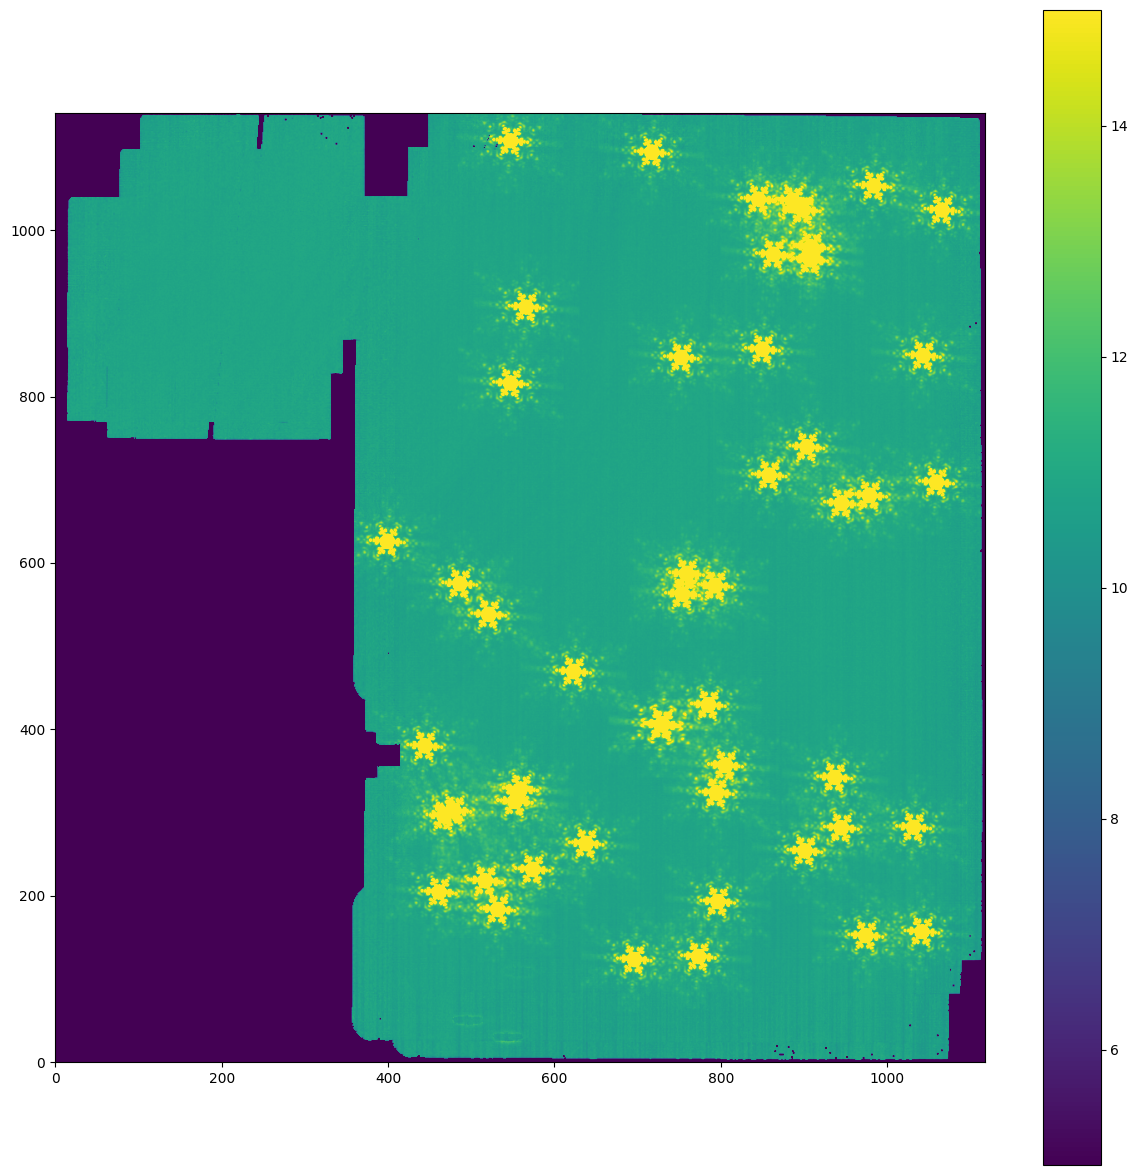

In [12]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table
from matplotlib.colors import LogNorm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

viz1 = LogStretch()
viz2 = LogStretch() + ManualInterval(-12,100)
norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

plt.figure(figsize=(15,15))
#plt.imshow(viz2(im_i2d.data),cmap='gray')
plt.imshow(im_i2d.data,origin='lower',vmin=5, vmax=15)
plt.colorbar()

### Display combined image with catalog sources overlaid

In [13]:
photfile = 'image3_combined_cat.ecsv'
data = table.Table.read(photfile, format='ascii', comment='#')
print(len(data),' sources detected')

46  sources detected


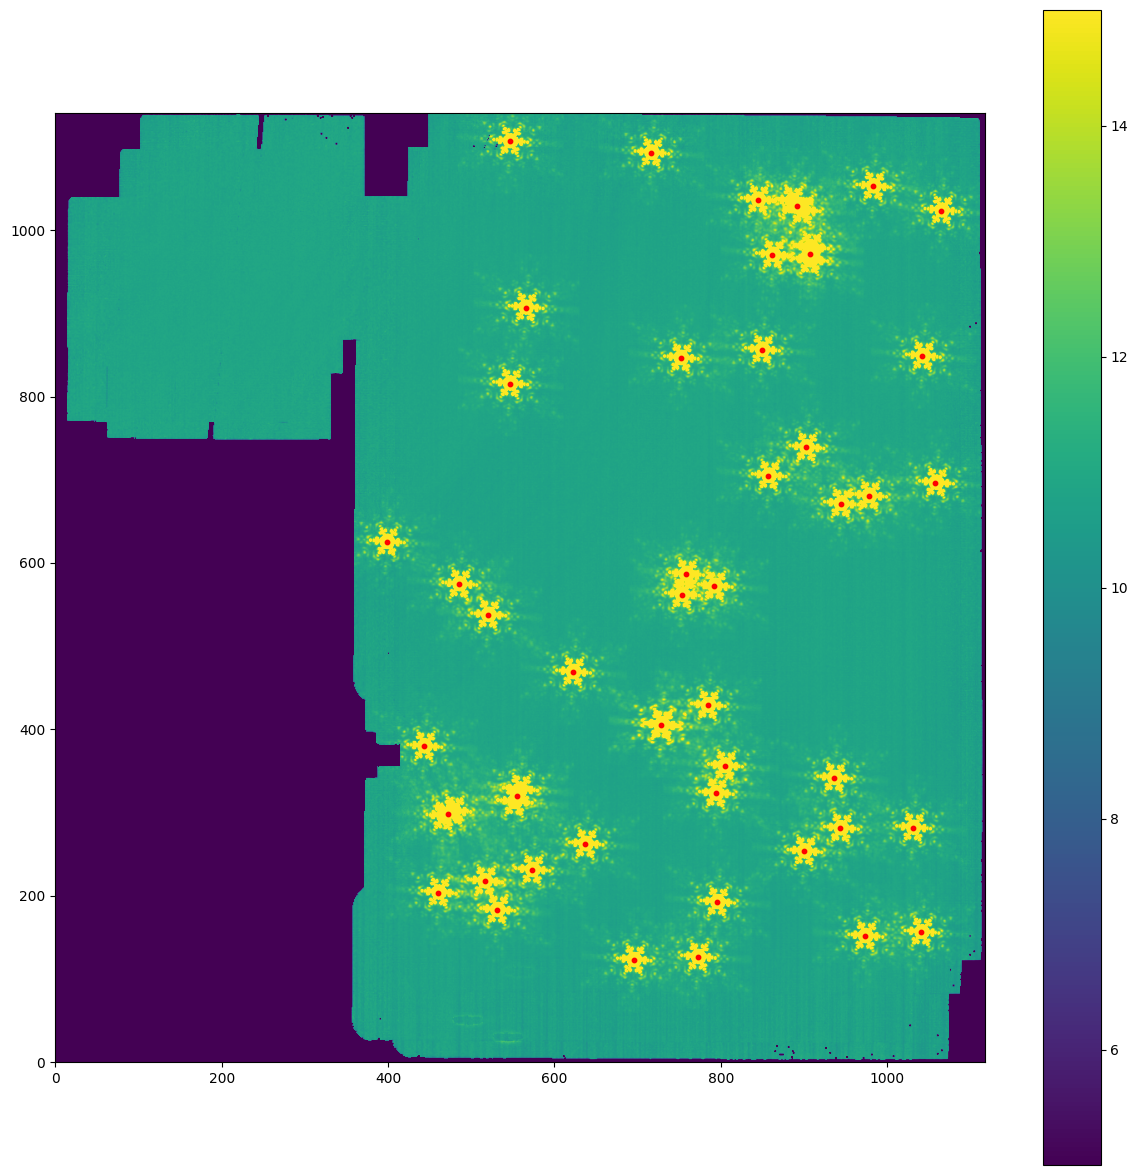

In [14]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table
from matplotlib.colors import LogNorm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

viz1 = LogStretch()
viz2 = LogStretch() + ManualInterval(-12,100)
norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

plt.figure(figsize=(15,15))
#plt.imshow(viz2(im_i2d.data),cmap='gray')
plt.imshow(im_i2d.data,origin='lower',vmin=5, vmax=15)
plt.colorbar()
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')